- Most/least responsive cells
- Most/least impactrul (damaging) drugs

- Most/least predictive cells (lowest error)
- Most/least predictive drugs (lowest error)

------------

- Encode count of cells/drugs
- Separate results by study

------------

- https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial
- https://seaborn.pydata.org/tutorial/distributions.html#distribution-tutorial

In [1]:
!which python

/vol/ml/apartin/anaconda3/envs/p1/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

In [3]:
runs_dir_name = 'out_lgbm'
file_path = Path.cwd()
print(file_path)

/vol/ml/apartin/projects/DrugResponseViz/notebooks


In [6]:
out_figs = file_path / 'out_figs_cls'
os.makedirs(out_figs, exist_ok=True)

In [7]:
runs_dir_path = Path(file_path / '..' / runs_dir_name)
runs_dirs = [Path(p) for p in glob(str(runs_dir_path/'run_*'))]
# pred = pd.read_csv(os.path.join(predsdir, 'dev_lgb_reg_preds.csv'))

In [8]:
# Load cell metadata
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
print(cancer_types.shape)
display(cancer_types[:2])

# cmeta = pd.read_csv(file_path/'../data/combined_metadata_2018May.txt', sep='\t')
# print(cmeta.shape)

# dmeta = pd.read_csv(file_path/'../data/drug_info', sep='\t')
# print(dmeta.shape)

(14590, 2)


,CELL,CTYPE
0,CCLE.ALLSIL,Acute_Lymphoblastic_Leukemia
1,CCLE.DND41,Acute_Lymphoblastic_Leukemia


In [9]:
# mltype = 'reg'
mltype = 'cls'

In [10]:
def plot_target(data_to_plot, y_name, x_name, kind='box', hue_name=None, height=None, aspect=None):
    """ Plot function. """
    if hue_name:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, hue=hue_name, **args);
    else:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, **args);
    return g

# Pre-proc data to analyze ML predictions

Combine predictions from all runs (shuffles/splits)

In [11]:
def reorg_cols(df):
    cols = df.columns.tolist()
    cols.remove('run')
    return df[['run'] + cols]
    
def agg_preds_from_runs(runs_dirs, resp_thres: float=0.5):
    """ Aggregate predictions bootstraped ML trainings.
    Args:
        resp_thres : response threshold for classification problem
    """
    prd_te = []
    for i, dir_name in enumerate(runs_dirs):
        # prd_tr_ = pd.read_csv(dir_name/'preds_tr.csv')
        # prd_vl_ = pd.read_csv(dir_name/'preds_vl.csv')
        prd_te_ = pd.read_csv(dir_name/'preds_te.csv')
        
        prd_te_['err'] = abs(prd_te_['y_true'] - prd_te_['y_pred'])      # add col 'err'
        prd_te_['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]  # add col 'run' identifier
        prd_te.append(prd_te_)  # append run data

        prd_te_['y_cls_true'] = [0 if v<resp_thres else 1 for v in prd_te_['y_true'].values]
        # prd_te_['y_cls_pred'] = prd_te_[]
        
        if i%20==0:
            print(f'Processing {dir_name}')
            
    # aggregate to df
    prd_te = pd.concat(prd_te, axis=0)
    return prd_te

In [12]:
# Concat preds from all runs      
prd_te = agg_preds_from_runs(runs_dirs)
prd_te = reorg_cols(prd_te)
prd_te = prd_te.reset_index().rename(columns={'index': 'idx'})
prd_te.insert(loc=2, column='source', value=[s.split('.')[0].lower() for s in prd_te['CELL']]) # add 'source' column

Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s000
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s020
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s040
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s060
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s080


In [13]:
prd_te[:2]

,idx,run,source,CELL,DRUG,AUC,y_true,y_pred,err
0,0,s000,ctrp,CTRP.Hs-729,CTRP.116,0.8039,0.8039,0.837310,0.033410
1,1,s000,ctrp,CTRP.NCI-H1184,CTRP.177,0.8107,0.8107,0.837507,0.026807


In [12]:
# Add meta
print(prd_te.shape)
prd_te = pd.merge(prd_te, cancer_types, how='left', on='CELL')
print(prd_te.shape)

(5299400, 9)
(5299400, 10)


# Pre-proc data to analyze raw response (w/o preds)
Get all responses from Top21.

Instead of Top21, we can use the entire response dataframe(?)

In [13]:
dir_name = runs_dirs[0]
prd_tr_ = pd.read_csv(dir_name/'preds_tr.csv')
prd_vl_ = pd.read_csv(dir_name/'preds_vl.csv')
prd_te_ = pd.read_csv(dir_name/'preds_te.csv')
rsp = pd.concat([prd_tr_, prd_vl_, prd_te_], axis=0)
rsp = rsp.reset_index().rename(columns={'index': 'idx'})
rsp.insert(loc=1, column='source', value=[s.split('.')[0].lower() for s in rsp['CELL']]) # add 'source' column

display(rsp[:2])

,idx,source,CELL,DRUG,AUC,y_true,y_pred
0,0,ctrp,CTRP.JHOC-5,CTRP.391,0.8934,0.8934,0.824278
1,1,gdsc,GDSC.CAKI-1,GDSC.157,0.6228,0.6228,0.717275


In [14]:
# Add meta
print(rsp.shape)
rsp = pd.merge(rsp, cancer_types, how='left', on='CELL')
print(rsp.shape)

(529940, 7)
(529940, 8)


# Cell Responsiveness

Are the cell names consistent across sources?

In [15]:
def agg_data_by_dim(df, col_name, dim):
    """
    Args:
        df  : 
        col : 'auc', 'err', etc.
        dim : either 'CELL' or 'DRUG'
    """
    aa = df.copy()
    
    center_col, center_func = col_name.lower()+'_median', np.median
    spread_col, spread_func = col_name.lower()+'_std', np.std
    aa[center_col] = aa[col_name]
    aa[spread_col] = aa[col_name]
            
    # aa = aa.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    if dim=='CELL':
        # aa = aa.groupby([dim]).agg({center_col: np.mean, std_col: np.std, 'idx': len, 'CTYPE': np.unique})
        aa = aa.groupby([dim]).agg({center_col: center_func, spread_col: np.std, 'idx': len, 'CTYPE': np.unique})
    else:
        aa = aa.groupby([dim]).agg({center_col: center_func, spread_col: np.std, 'idx': len})
    aa = aa.rename(columns={'idx': 'cnt'})
    aa = aa.reset_index()        
    return aa

In [16]:
# def agg_rsp_by_dim(df, dim):
#     """ Aggregate response by 'dim' where dim is either 'CELL' or 'DRUG'. """
#     df_ = df.copy()
    
#     mean_col = 'auc_mean'
#     std_col  = 'auc_std'
#     df_[mean_col] = df_['AUC']
#     df_[std_col]  = df_['AUC']
#     # rsp_[f'{col.lower()}_mean'] = rsp_[col]
#     # rsp_[f'{col.lower()}_std'] = rsp_[col]
        
#     # df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
#     if dim=='CELL':
#         df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len, 'CTYPE': np.unique})
#     else:
#         df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
#     df_ = df_.rename(columns={'idx': 'cnt'})
#     df_ = df_.reset_index()
#     return df_    

In [17]:
dim='CELL'
col_name='AUC'
# rsp_cell = agg_rsp_by_dim(rsp, dim=dim)
rsp_cell = agg_data_by_dim(rsp, col_name=col_name, dim=dim)
rsp_cell[:2]

,CELL,auc_median,auc_std,cnt,CTYPE
0,CCLE.22RV1,0.80995,0.162658,24,Prostate_Adenocarcinoma
1,CCLE.42MGBA,0.80755,0.172672,20,Glioblastoma_Multiforme


In [18]:
# Get the N most responsive cells
N = 5
col = col_name.lower()+'_median'

# Most responsive cells
most_rsp_cells = rsp_cell.sort_values(col, ascending=True)[:N]
display(most_rsp_cells[:2])

# Least responsive cells
least_rsp_cells = rsp_cell.sort_values(col, ascending=True)[-N:]
display(least_rsp_cells[:2])

,CELL,auc_median,auc_std,cnt,CTYPE
427,CTRP.HCC-33,0.37785,0.219620,4,Lung_Small_Cell_Carcinoma
729,CTRP.SCLC-21H,0.40490,0.192537,15,Lung_Small_Cell_Carcinoma


,CELL,auc_median,auc_std,cnt,CTYPE
1141,GDSC.NCI-H2291,0.96590,0.116084,212,Lung_Adenocarcinoma
746,CTRP.SK-MEL-28,0.96675,0.088636,420,Skin_Cutaneous_Melanoma


In [19]:
# Agg most and least responsive cells
names = most_rsp_cells[dim].tolist()
names.extend( least_rsp_cells[dim].tolist() )

tmp_rsp = rsp[ rsp[dim].isin(names) ].copy()
print(tmp_rsp[dim].unique())
print(tmp_rsp.shape)

display(tmp_rsp[:2])

['CTRP.BEN' 'CTRP.SK-MEL-28' 'CTRP.LS-411N' 'CTRP.CL-34' 'GDSC.SW1116'
 'GDSC.NCI-H2291' 'gCSI.IGROV-1' 'gCSI.CI-1' 'CTRP.SCLC-21H' 'CTRP.HCC-33']
(1658, 8)


,idx,source,CELL,DRUG,AUC,y_true,y_pred,CTYPE
311,311,ctrp,CTRP.BEN,CTRP.417,0.9999,0.9999,1.001199,Lung_Non-Small_Cell_Carcinoma
413,413,ctrp,CTRP.SK-MEL-28,CTRP.105,0.9906,0.9906,0.971284,Skin_Cutaneous_Melanoma


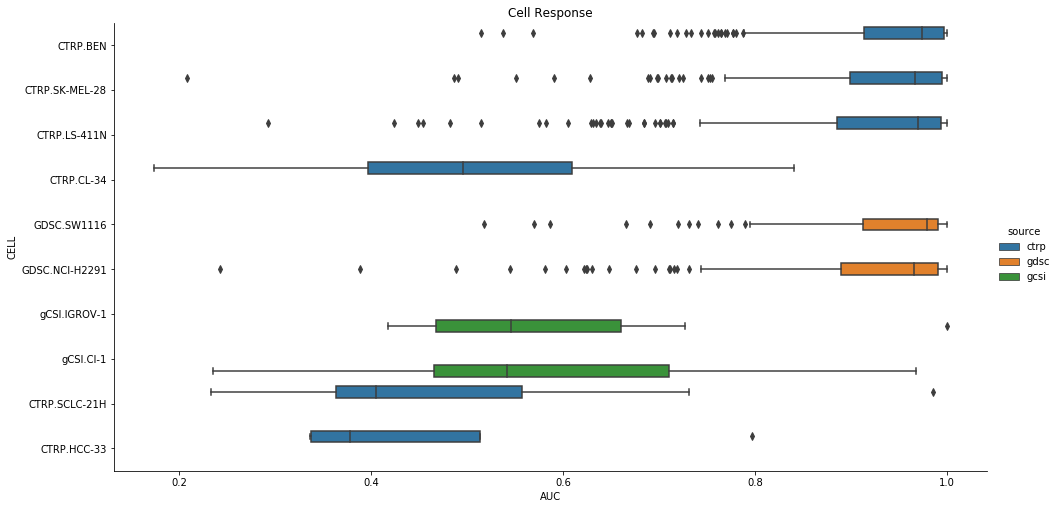

In [22]:
# https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
y_name='CELL'
x_name='AUC'
hue_name='source'
# hue_name='CTYPE'
data_to_plot=tmp_rsp
args={'height': 7, 'aspect': 2}
    
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='strip', hue_name=hue_name, **args)
g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='box', hue_name=hue_name, **args)
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='violin', hue_name=hue_name, **args)

plt.title('Cell Response')
plt.savefig(out_figs/f'cell_response_{hue_name.lower()}.png', dpi=100)

In [21]:
# fig, ax = plt.subplots()
# rects1 = ax.barh(y=dd['CELL'], width=dd['auc_median'], xerr=dd['auc_std'], align='center', label='Men')

# Drug Impactfulness

In [23]:
dim='DRUG'
col_name='AUC'
rsp_drug = agg_data_by_dim(rsp, col_name=col_name, dim=dim)
rsp_drug = rsp_drug.reset_index()

In [25]:
# Get the N most and least impactful drugs
N = 5
col = col_name.lower()+'_median'

# Most responsive cells
most_rsp_drugs = rsp_drug.sort_values(col, ascending=True)[:N]
display(most_rsp_drugs[:2])

# Least responsive cells
least_rsp_drugs = rsp_drug.sort_values(col, ascending=True)[-N:]
display(least_rsp_drugs[:2])

,index,DRUG,auc_median,auc_std,cnt
1139,1139,NSC.747973,0.1712,0.145005,162
553,553,GDSC.104,0.2626,0.202973,185


,index,DRUG,auc_median,auc_std,cnt
916,916,NSC.624780,0.99910,0.007719,25
907,907,NSC.619130,0.99915,0.008412,46


In [26]:
# Agg most and least impactful drugs
names = most_rsp_drugs[dim].tolist()
names.extend( least_rsp_drugs[dim].tolist() )

tmp_rsp = rsp[ rsp[dim].isin(names) ].copy()
print(tmp_rsp[dim].unique())
print(tmp_rsp.shape)

['GDSC.268' 'GDSC.1001' 'NSC.747973' 'CTRP.309' 'GDSC.104' 'GDSC.201'
 'NSC.619130' 'NSC.624360' 'NSC.750679' 'NSC.624780']
(2312, 8)


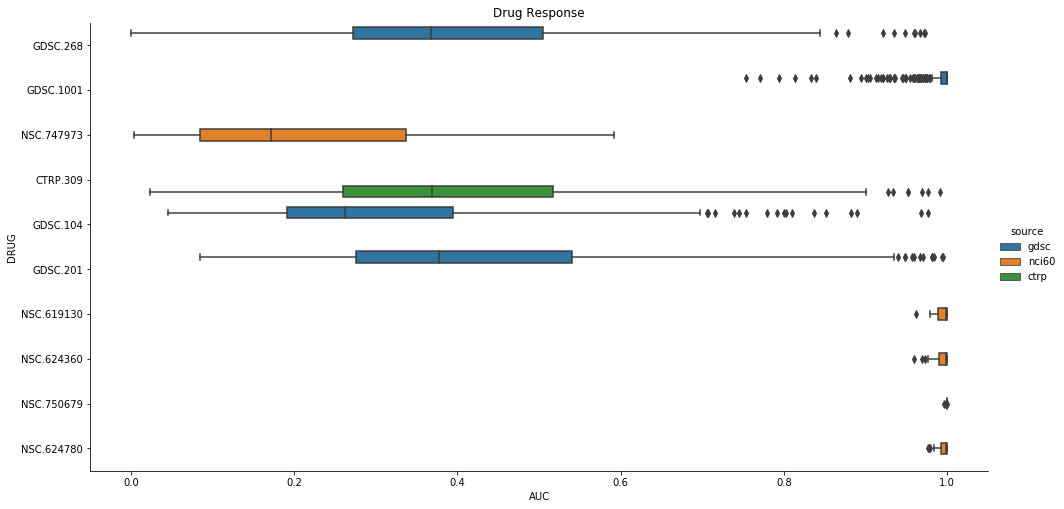

In [28]:
# https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
y_name='DRUG'
x_name='AUC'
hue_name='source'
# hue_name='DTYPE'
data_to_plot=tmp_rsp
args={'height': 7, 'aspect': 2}
    
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='strip', hue_name=hue_name, **args)
g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='box', hue_name=hue_name, **args)
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='violin', hue_name=hue_name, **args)

plt.title('Drug Response')
plt.savefig(out_figs/f'drug_response_{hue_name.lower()}.png', dpi=100)

# Cell Predictiveness

In [26]:
def agg_prd_by_dim(df, dim):
    df_ = df.copy()
    
    # mean_col = 'err_mean', np.mean
    center_col, center_func = 'err_median', np.median
    spread_col, spread_func  = 'err_std', np.std
    df_[center_col] = df_['err']
    df_[spread_col]  = df_['err']
    # rsp_[f'{col.lower()}_mean'] = rsp_[col]
    # rsp_[f'{col.lower()}_std'] = rsp_[col]
        
    # df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    if dim=='CELL':
        # df_ = df_.groupby([dim]).agg({center_col: np.mean, std_col: np.std, 'idx': len, 'CTYPE': np.unique})
        df_ = df_.groupby([dim]).agg({center_col: center_func, spread_col: np.std, 'idx': len, 'CTYPE': np.unique})
    else:
        df_ = df_.groupby([dim]).agg({center_col: center_func, spread_col: np.std, 'idx': len})
    df_ = df_.rename(columns={'idx': 'cnt'})
    df_ = df_.reset_index()        
    return df_  

In [29]:
dim='CELL'
col_name='err'
# prd_cell = agg_prd_by_dim(prd_te, dim=dim)
prd_cell = agg_data_by_dim(prd_te, col_name=col_name, dim=dim)
prd_cell[:2]

,CELL,err_median,err_std,cnt,CTYPE
0,CCLE.22RV1,0.050735,0.060342,234,Prostate_Adenocarcinoma
1,CCLE.42MGBA,0.062824,0.083734,210,Glioblastoma_Multiforme


In [30]:
# Get the N most responsive cells
N = 5
# center_col='err_median'
col=col_name+'_median'

# Most responsive cells
most_prd_cells = prd_cell.sort_values(col, ascending=True)[:N]
display(most_prd_cells[:2])

# Least responsive cells
least_prd_cells = prd_cell.sort_values(col, ascending=True)[-N:]
display(least_prd_cells[:2])

,CELL,err_median,err_std,cnt,CTYPE
1432,gCSI.HCC2218,0.017756,0.080157,49,Breast_Invasive_Carcinoma
1495,gCSI.MEWO,0.020751,0.043211,167,Skin_Cutaneous_Melanoma


,CELL,err_median,err_std,cnt,CTYPE
1463,gCSI.KMM-1,0.156426,0.119862,138,Lymphoid_Leukemia
1470,gCSI.KU812,0.156618,0.065952,163,Chronic_Myeloid_Leukemia


In [31]:
# Agg most and least responsive cells
names = most_prd_cells[dim].tolist()
names.extend( least_prd_cells[dim].tolist() )

tmp_prd_te = prd_te[ prd_te[dim].isin(names) ].copy()
print(tmp_prd_te[dim].unique())
print(tmp_prd_te.shape)


['gCSI.MEWO' 'gCSI.EKVX' 'CTRP.CL-34' 'gCSI.AM-38' 'CCLE.NCIH2009'
 'gCSI.KU812' 'CCLE.SW1573' 'CTRP.HCC-33' 'gCSI.KMM-1' 'gCSI.HCC2218']
(1461, 10)


In [32]:
tmp_prd_te[:2]

,idx,run,source,CELL,DRUG,AUC,y_true,y_pred,err,CTYPE
11346,11346,s000,gcsi,gCSI.MEWO,gCSI.14,0.7650,0.7650,0.761117,0.003883,Skin_Cutaneous_Melanoma
11809,11809,s000,gcsi,gCSI.EKVX,gCSI.3,0.7379,0.7379,0.835252,0.097352,Lung_Adenocarcinoma


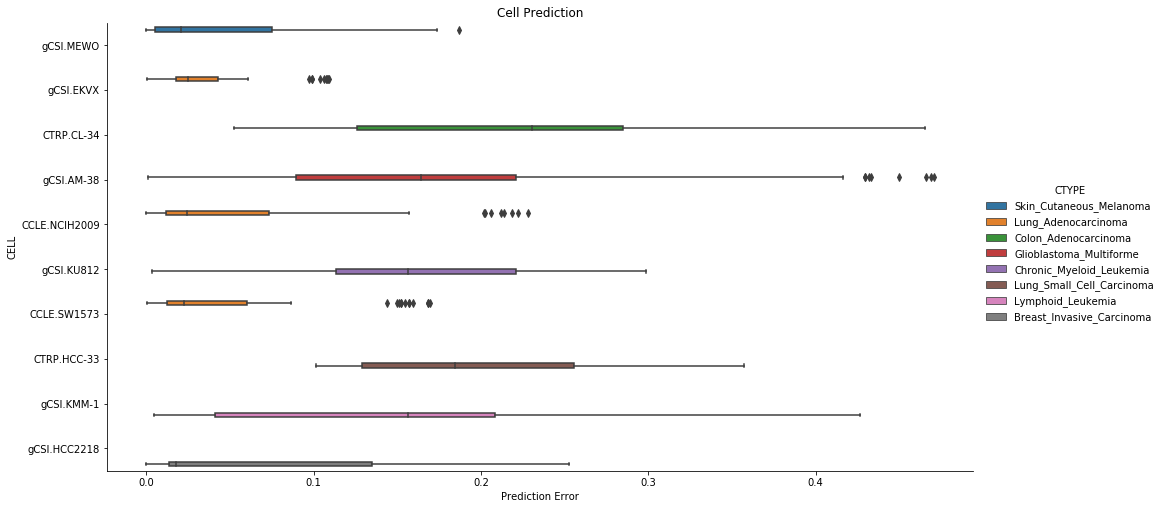

In [34]:
# https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
y_name='CELL'
x_name='err'
hue_name='source'
# hue_name='CTYPE'
data_to_plot=tmp_prd_te
args={'height': 7, 'aspect': 2}
    
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='strip', hue_name=hue_name, **args)
g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='box', hue_name=hue_name, **args)
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='violin', hue_name=hue_name, **args)

plt.xlabel('Prediction Error');

plt.title('Cell Prediction')
plt.savefig(out_figs/f'cell_prediction_{hue_name.lower()}.png', dpi=100)

# Drug Predictiveness

In [38]:
dim='DRUG'
col_name='err'
# prd_drug = agg_prd_by_dim(prd_te, dim=dim)
prd_drug = agg_data_by_dim(prd_te, col_name, dim=dim)
prd_drug[:2]

,DRUG,err_median,err_std,cnt
0,CCLE.1,0.048272,0.042345,3055
1,CCLE.10,0.054430,0.052287,3174


In [39]:
# Get the N most responsive cells
N = 5
# center_col='err_median'
col=col_name+'_median'

# Most responsive cells
most_prd_drugs = prd_drug.sort_values(col, ascending=True)[:N]
display(most_prd_drugs[:2])

# Least responsive cells
least_prd_drugs = prd_drug.sort_values(col, ascending=True)[-N:]
display(least_prd_drugs[:2])

,DRUG,err_median,err_std,cnt
840,NSC.32065,0.012174,0.040742,13956
812,NSC.25154,0.012801,0.027527,18926


,DRUG,err_median,err_std,cnt
547,GDSC.1031,0.200608,0.103602,3989
166,CTRP.235,0.206491,0.116286,4312


In [40]:
# Agg most and least responsive cells
names = most_prd_drugs[dim].tolist()
names.extend( least_prd_drugs[dim].tolist() )

tmp_prd_te = prd_te[ prd_te[dim].isin(names) ].copy()
print(tmp_prd_te[dim].unique())
print(tmp_prd_te.shape)


['NSC.409962' 'NSC.25154' 'NSC.32065' 'CTRP.235' 'GDSC.1031' 'NSC.152149'
 'NSC.174939' 'NSC.364372' 'NSC.754345' 'NSC.697926']
(92888, 10)


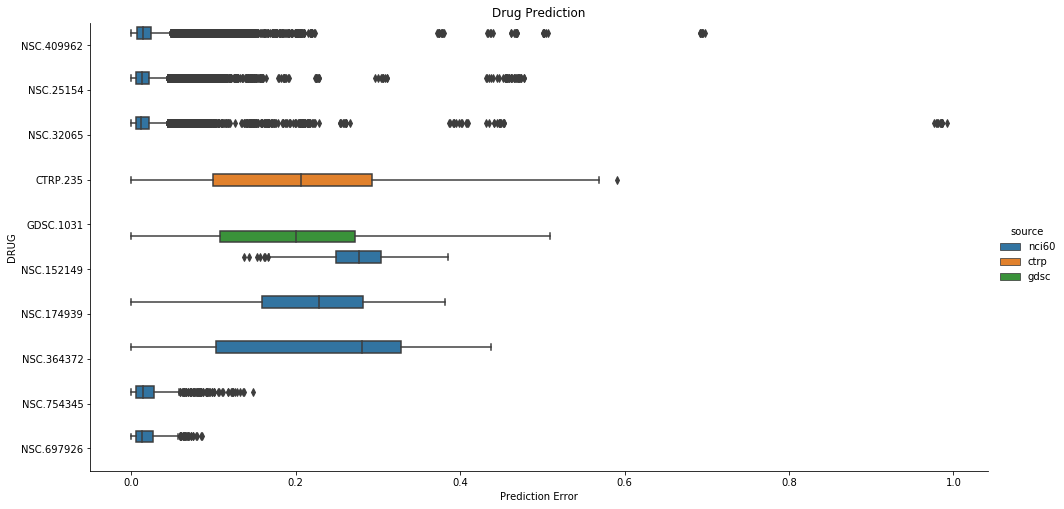

In [41]:
# https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
y_name='DRUG'
x_name='err'
hue_name='source'
# hue_name='CTYPE'
data_to_plot=tmp_prd_te
args={'height': 7, 'aspect': 2}
    
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='strip', hue_name=hue_name, **args)
g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='box', hue_name=hue_name, **args)
# g = plot_target(data_to_plot, y_name=y_name, x_name=x_name, kind='violin', hue_name=hue_name, **args)

plt.xlabel('Prediction Error');

plt.title('Drug Prediction')
plt.savefig(out_figs/f'drug_prediction_{hue_name.lower()}.png', dpi=100)